# 2. Linesearch
For this training course we'll be using the optimization routines in SciPy.

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

We also need to define a callback function so that we can plot the optimization steps.

In [2]:
def callback(x):
    global xprev
    plt.plot([xprev[0],x[0]],[xprev[1],x[1]],'b.-')
    xprev = x

## 2.1 Naive Linesearch Methods
Consider the quadratic optimization problem

$
\begin{align}
\min_{x} f(x) = \frac{1}{2}(a x_1^2 + x_2^2)
\end{align}
$

for some $a >0$.

The gradient for this problem is

$
\begin{align}
\nabla f(x) = 
\begin{pmatrix}
a x_1 \\
x_2
\end{pmatrix}
\end{align}
$

and thus $x^* = 0$ is the stationary point.

The Hessian for this problem is

$
\begin{align}
\nabla^2 f(x) = 
\begin{pmatrix}
a & 0 \\
0 & 1
\end{pmatrix} 
\succ 0
\end{align}
$

and hence (as $a >0$) the problem is convex, so $x^* = 0$ is the unique global minimizer.

### 2.1.1 Steepest Descent
Recall that steepest descent proceeds as a step of the form

$
\begin{align}
x^{k+1} = x^k + \alpha^k p^k
\end{align}
$

along the steepest descent direction 

$
\begin{align}
p^k = -\nabla f(x^k)
\end{align}
$ 

with step-size $\alpha^k$ obtained by linesearch. For convex quadratics, we have an explicit formula for exact linesearch:

$
\begin{align}
\alpha^k = -\frac{(p^k)^T \nabla f(x^k)}{(p^k)^T\nabla^2f(x^k)p^k} = \frac{\nabla f(x^k)^T\nabla f(x^k)}{\nabla f(x^k)^T \nabla^2 f(x^k) \nabla f(x^k)} = \frac{a^2 (x_1^k)^2 + (x_2^k)^2}{a^3 (x_1^k)^2 + (x_2^k)^2}
\end{align}
$

for our specific quadratic objective function $f(x) = 0.5(a x_1^2 + x_2^2)$ defined above.

In [3]:
# Textbook steepest descent method with exact linesearch for 0.5(ax_1^2+x_2^2)
# fun - objective function 
# x0 - starting point
# jac - objective function gradient
# tol - tolerance for termination
# callback - callback function (for plotting)
def steepest_descent(fun, x0, args=(), jac=None, tol=1e-1, callback=None, **options):
    
    x = x0
    it = 0
    while np.linalg.norm(jac(x)) > tol: # first-order optimality (zero gradient)
        alpha = ((a**2)*x[0]**2 + x[1]**2)/((a**3)*x[0]**2 + x[1]**2) # exact linesearch for 0.5(ax_1^2+x_2^2)
        x = x + alpha*(-jac(x)) # steepest descent iteration

        if callback is not None: # callback function (for plotting)
            callback(x)
            
        it += 1 # number of iterations
        
    return opt.OptimizeResult(x=x, fun=fun(x), jac=jac(x), nit=it, success=True)

#### Coding Task:
Now apply the steepest descent method starting from $x^0 = (1,a)$ to solve the above problem for various values of $a$.

     fun: 0.002414648411261648
     jac: array([-0.06625911,  0.06625911])
     nit: 25
 success: True
       x: array([-0.00662591,  0.06625911])


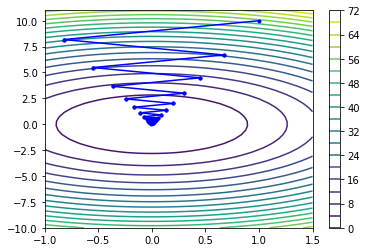

In [4]:
# Scaling parameter
a = 10

# Initial guess
x0 = np.array([1,a])

# Objective function and gradient
fun = lambda x: 0.5*(a*x[0]**2+x[1]**2)
jac = lambda x: np.array([a*x[0],x[1]])

# Plot function contours
plt.figure()
X = np.linspace(-1,1.5)
Y = np.linspace(-a,a+1)
Z = np.meshgrid(X,Y)
plt.contour(X,Y,fun(Z),20)
plt.colorbar()

# Call steepest descent via scipy
xprev = x0 # for plotting
res = opt.minimize(fun, x0, method=steepest_descent, jac=jac, tol=1e-1, callback=callback)

# Print results and show plot
print(res)
plt.show()

What is going on here? Steepest descent is sensitive to problem scaling: one can show that each iterate is

$
\begin{align}
x^k = 
\left(
\frac{a-1}{a+1}
\right)^k
\begin{pmatrix}
(-1)^k \\
a
\end{pmatrix}
\end{align}
$

and thus the iterates jump around. Moreover since 

$
\begin{align}
\frac{\lVert x^{k+1} - x^* \rVert}{\lVert x^k - x^* \rVert} = \frac{\lVert x^{k+1} - 0 \rVert}{\lVert x^k - 0 \rVert} = \left| \frac{a-1}{a+1} \right| < 1
\end{align}
$

the convergence is linear with rate $|(a-1)/(a+1)|$ and the closer to $1$ this is (the larger $a$ is) the more iterations will be needed to converge. 

### 2.1.2 (Damped) Newton's Method
Recall that (damped) Newton's method proceeds as a step of the form

$
\begin{align}
x^{k+1} = x^k + \alpha^k p^k
\end{align}
$

along the Newton direction $p^k$ which solves

$
\begin{align}
\nabla^2 f(x^k) \, p^k = -\nabla f(x^k)
\end{align}
$ 

with step-size $\alpha^k$ obtained by linesearch. For convex quadratics, we have an explicit formula for exact linesearch:

$
\begin{align}
\alpha^k = -\frac{(p^k)^T \nabla f(x^k)}{(p^k)^T\nabla^2f(x^k)p^k} = \frac{\left(\nabla^2 f(x^k)^{-1}\nabla f(x^k)\right)^T\nabla f(x^k)}{\left(\nabla^2 f(x^k)^{-1}\nabla f(x^k)\right)^T \nabla^2 f(x^k) \nabla^2 f(x^k)^{-1}\nabla f(x^k)} = \, 1
\end{align}
$

for any convex quadratic.

In [5]:
# Textbook (damped) Newton method with exact linesearch for for convex quadratics
# fun - objective function 
# x0 - starting point
# jac - objective function gradient
# hess - objective function Hessian
# tol - tolerance for termination
# callback - callback function (for plotting)
def newton(fun, x0, args=(), jac=None, hess=None, tol=1e-1, callback=None, **options):
    
    x = x0
    it = 0
    while np.linalg.norm(jac(x)) > tol: # first-order optimality (zero gradient)
        alpha = 1 # exact linesearch for convex quadratics
        x = x + alpha*np.linalg.solve(hess(x),-jac(x)) # Newton iteration

        if callback is not None: # callback function (for plotting)
            callback(x)
            
        it += 1 # number of iterations
        
    return opt.OptimizeResult(x=x, fun=fun(x), jac=jac(x), hess=hess(x), nit=it, success=True)

#### Coding Task: 
Now apply Newton's method starting from $x^0 = (1,a)$ to solve the above problem for various values of $a$.

     fun: 0.0
    hess: array([[10,  0],
       [ 0,  1]])
     jac: array([0., 0.])
     nit: 1
 success: True
       x: array([0., 0.])


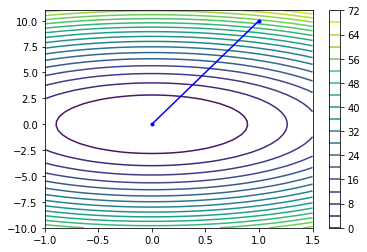

In [6]:
# Scaling parameter
a = 10

# Initial guess
x0 = np.array([1,a])

# Objective function, gradient and Hessian
fun = lambda x: 0.5*(a*x[0]**2+x[1]**2)
jac = lambda x: np.array([a*x[0],x[1]])
hess = lambda x: np.array([[a,0],[0,1]])

# Plot function contours
plt.figure()
X = np.linspace(-1,1.5)
Y = np.linspace(-a,a+1)
Z = np.meshgrid(X,Y)
plt.contour(X,Y,fun(Z),20)
plt.colorbar()

# Call Newton's method via scipy
xprev = x0 # for plotting
res = opt.minimize(fun, x0, method=newton, jac=jac, hess=hess, tol=1e-1, callback=callback)

# Print results and show plot
print(res)
plt.show()

What is going on here? Newton's method is not sensitive to problem scaling: the first iterate is

$
\begin{align}
x^1 = x^0 - \nabla^2 f(x^0)^{-1}\nabla f(x^0) = x^0 - 
\begin{pmatrix}
1/a & 0 \\
0 & 1
\end{pmatrix}
\begin{pmatrix}
a x_1^0 \\
x_2^0
\end{pmatrix}
= x^0 - x^0 = 0 = x^*
\end{align}
$

and thus we converge in one step. Moreover, consider the general convex quadratic

$
\begin{align}
f(x) = \frac{1}{2}x^TAx + b^Tx
\end{align}
$

with $A \succ 0$, then (solving $\nabla f(x) = 0$) we get that $x^* = -A^{-1}b$ and 

$
\begin{align}
x^1 = x^0 - \nabla^2 f(x^0)^{-1}\nabla f(x^0) = x^0 - A^{-1}(Ax^0 + b) = -A^{-1}b = x^*
\end{align}
$

therefore Newton's method converges in one step for any convex quadratic! 

### 2.1.3 Conjugate Gradient Method
Recall that for a general convex quadratic ($A \succ 0$)

$
\begin{align}
f(x) = \frac{1}{2}x^TAx + b^Tx
\end{align}
$

the conjugate gradient method proceeds as steps of the form

$
\begin{align}
x^{k+1} = x^k + \alpha^k p^k
\end{align}
$

along the conjugate directions 

$
\begin{align}
p^k = -\nabla f(x^k) + \beta^k p^{k-1}
\end{align}
$ 

where $\beta^k$ is chosen to ensure $A$-conjugacy of the directions

$
\begin{align}
\beta_k = \frac{\nabla f(x^k)^T\nabla f(x^k)}{\nabla f(x^{k-1})^T\nabla f(x^{k-1})}
\end{align}
$

and the step-size $\alpha^k$ is given by exact linesearch (from our explicit formula)

$
\begin{align}
\alpha^k = \frac{\nabla f(x^k)^T \nabla f(x^k)}{(p^k)^TAp^k}. 
\end{align}
$

In [7]:
# Textbook conjugate gradient method for convex quadratics
# fun - objective function 
# x0 - starting point
# jac - objective function gradient
# hess - objective function Hessian
# tol - tolerance for termination
# callback - callback function (for plotting)
def conjugate_gradient(fun, x0, args=(), jac=None, hess=None, tol=1e-1, callback=None, **options):
    
    x = x0
    g = jac(x)
    A = hess(x)
    p = -g
    it = 0
    while np.linalg.norm(g) > tol: # first-order optimality (zero gradient)
        alpha = g.T.dot(g)/p.T.dot(A.dot(p)) # exact linesearch
        x = x + alpha*p # take step
        gnew = g + alpha*A.dot(p) # new gradient
        beta = gnew.dot(gnew)/g.dot(g)
        p = -gnew + beta*p # new conjugate direction
        g = gnew
        
        if callback is not None: # callback function (for plotting)
            callback(x)
            
        it += 1 # number of iterations
        
    return opt.OptimizeResult(x=x, fun=fun(x), jac=jac(x), hess=hess(x), nit=it, success=True)

#### Coding Task: 
Now apply conjugate gradient starting from $x^0 = (1,a)$ to solve the above problem for various values of $a$.

     fun: 2.1323896344255475e-30
    hess: array([[10,  0],
       [ 0,  1]])
     jac: array([-3.33066907e-15, -1.77635684e-15])
     nit: 2
 success: True
       x: array([-3.33066907e-16, -1.77635684e-15])


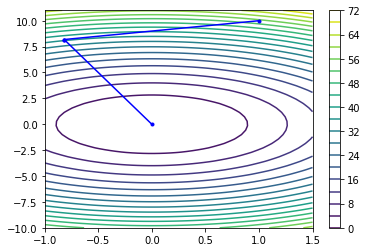

In [8]:
# Scaling parameter
a = 10

# Initial guess
x0 = np.array([1,a])

# Objective function, gradient and Hessian
fun = lambda x: 0.5*(a*x[0]**2+x[1]**2)
jac = lambda x: np.array([a*x[0],x[1]])
hess = lambda x: np.array([[a,0],[0,1]])

# Plot function contours
plt.figure()
X = np.linspace(-1,1.5)
Y = np.linspace(-a,a+1)
Z = np.meshgrid(X,Y)
plt.contour(X,Y,fun(Z),20)
plt.colorbar()

# Call Newton's method via scipy
xprev = x0 # for plotting
res = opt.minimize(fun, x0, method=conjugate_gradient, jac=jac, hess=hess, tol=1e-1, callback=callback)

# Print results and show plot
print(res)
plt.show()

What is going on here? Conjugate gradient is guaranteed to converge in at most as many iterations as there are dimensions of the problem, in this case since we are in 2D that means just two iterations! 

In practice, convergence speed depends on the spectrum of the Hessian (and can be much faster for large problems):

$
\begin{align}
\frac{\lVert x^k - x^* \rVert_A}{\lVert x^0 - x^* \rVert_A}
\le 2 \left( \frac{\sqrt{\kappa(A)}-1}{\sqrt{\kappa(A)}+1} \right)^k
\end{align}
$

where $\kappa(A)$ is the Hessian condition number.

## 2.2 More Sophisticated Linesearch Methods
Consider the Rosenbrock function defined as

$
f(x) = (a - x_1)^2 + b(x_2 - x_1^2)^2
$

where usually $a=1$ and $b=100$.

#### Exercises: 
1. Find the stationary point $x^*$ of this function.
2. Compute numerically the eigenvalue of the Hessian at $x^*$ to verify that $x^*$ is a minimum.

#### Answers:
The gradient for this function is

$
\begin{align}
\nabla f(x) = 
\begin{pmatrix}
-2(a - x_1) -2x_1 2b(x_2 - x_1^2) \\
2b(x_2 - x_1^2)
\end{pmatrix}
\end{align}
$

and thus $x^* = (a,a^2)$ is the stationary point.

The Hessian for this function is

$
\begin{align}
\nabla^2 f(x) = 
\begin{pmatrix}
2 -4bx_2 +12bx_1^2 & -4bx_1 \\
-4bx_1 & 2b
\end{pmatrix}
\end{align}
$

and since 

$
\begin{align}
\nabla^2 f(x^*) = 
\begin{pmatrix}
2 +8ba^2 & -4ba \\
-4ba & 2b
\end{pmatrix}
\succ 0
\end{align}
$

$x^* = (a,a^2)$ is the minimizer, which is global since $f(x^*) = 0$.

### 2.2.1 Nonlinear Conjugate Gradient
Recall that nonlinear conjugate gradient proceeds as a step of the form

$
\begin{align}
x^{k+1} = x^k + \alpha^k p^k
\end{align}
$

along the conjugate direction

$
\begin{align}
p^k = -\nabla f(x^k) + \beta^k p^{k-1}
\end{align}
$ 

where $\beta^k$ is chosen to ensure conjugacy of the directions, several choices are possible here, e.g. Fletcher-Reeves:

$
\begin{align}
\beta_k = \frac{\nabla f(x^k)^T\nabla f(x^k)}{\nabla f(x^{k-1})^T\nabla f(x^{k-1})}
\end{align}
$

and the step-size $\alpha^k$ is obtained by suitable linesearch.

#### Coding Task: 
Now apply Scipy's CG starting from $x^0 = (2a,2a)$ to solve the above problem for $a=1$ and $b=100$. Then try again from $x^0 = (10a,10a)$.

     fun: 0.0002630476487862676
     jac: array([0.00612101, 0.0129357 ])
 message: 'Optimization terminated successfully.'
    nfev: 21
     nit: 9
    njev: 21
  status: 0
 success: True
       x: array([1.01620584, 1.03273899])


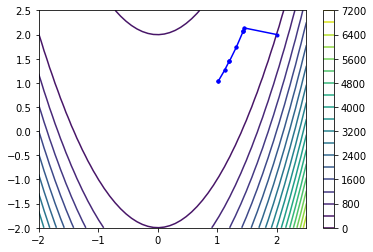

In [9]:
# Parameters
a = 1
b = 100

# Initial guess
x0 = np.array([2*a,2*a])

# Objective function and gradient
fun = lambda x: (a-x[0])**2 + b*(x[1]-x[0]**2)**2
jac = lambda x: np.array([-2*(a-x[0])-2*x[0]*2*b*(x[1]-x[0]**2),2*b*(x[1]-x[0]**2)])

# Plot function contours
plt.figure()
X = np.linspace(-2,2.5)
Y = np.linspace(-2,2.5)
Z = np.meshgrid(X,Y)
plt.contour(X,Y,fun(Z),20)
plt.colorbar()

# Call Scipy's CG
xprev = x0 # for plotting
res = opt.minimize(fun, x0, method='CG', jac=jac, tol=1e-1, callback=callback)

# Print results and show plot
print(res)
plt.show()

### 2.2.2 Truncated Newton
Recall that Truncated Newton methods proceed as a step of the form

$
\begin{align}
x^{k+1} = x^k + \alpha^k p^k
\end{align}
$

along the approximate Newton direction $p^k$ which approximately solves

$
\begin{align}
\nabla^2 f(x^k) \, p^k \approx -\nabla f(x^k)
\end{align}
$ 

for example, using a limited number of conjugate-gradient iterations.

#### Coding Task: 
Now apply Scipy's Newton-CG starting from $x^0 = (2a,2a)$ to solve the above problem for $a=1$ and $b=100$. Then try again from $x^0 = (10a,10a)$.

     fun: 2.8378641430679393e-16
     jac: array([ 5.56370924e-06, -2.79313233e-06])
 message: 'Optimization terminated successfully.'
    nfev: 37
    nhev: 24
     nit: 24
    njev: 37
  status: 0
 success: True
       x: array([0.99999998, 0.99999997])


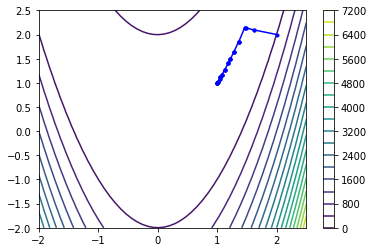

In [10]:
# Parameters
a = 1
b = 100

# Initial guess
x0 = np.array([2*a,2*a])

# Objective function, gradient and Hessian
fun = lambda x: (a-x[0])**2 + b*(x[1]-x[0]**2)**2
jac = lambda x: np.array([-2*(a-x[0])-2*x[0]*2*b*(x[1]-x[0]**2),2*b*(x[1]-x[0]**2)])
hess = lambda x: np.array([[2-4*b*x[1]+12*b*x[0]**2,-4*b*x[0]],[-4*b*x[0],2*b]])

# Plot function contours
plt.figure()
X = np.linspace(-2,2.5)
Y = np.linspace(-2,2.5)
Z = np.meshgrid(X,Y)
plt.contour(X,Y,fun(Z),20)
plt.colorbar()

# Call Scipy's Newton-CG
xprev = x0 # for plotting
res = opt.minimize(fun, x0, method='Newton-CG', jac=jac, hess=hess, callback=callback)

# Print results and show plot
print(res)
plt.show()

### 2.2.3 Quasi-Newton
Recall that Quasi-Newton proceed as a step of the form

$
\begin{align}
x^{k+1} = x^k + \alpha^k p^k
\end{align}
$

along the Quasi-Newton direction $p^k$ which solves

$
\begin{align}
B^k \, p^k = -\nabla f(x^k)
\end{align}
$ 

where $B^k$ is a suitable approximation to $\nabla^2 f(x^k)$, chosen to statisfy the secant equation

$
\begin{align}
B^{k+1} (x^{k+1} - x^k) = \nabla f(x^{k+1}) - \nabla f(x^k)
\end{align}
$

For example, one of the most popular approximations is BFGS (a rank two update)

$
\begin{align}
B^{k+1} = B^k + \frac{y^k(y^k)^T}{(y^k)^Ts^k} - \frac{B^ks^k(B^ks^k)^T}{(s^k)^TB^ks^k}
\end{align}
$

where $s^k = x^{k+1} - x^k$ and $y^k = \nabla f(x^{k+1}) - \nabla f(x^k)$.

#### Coding Task: 
Now apply Scipy's BFGS starting from $x^0 = (2a,2a)$ to solve the above problem for $a=1$ and $b=100$. Then try again from $x^0 = (10a,10a)$.

      fun: 1.2472338472171815e-06
 hess_inv: array([[0.4298175 , 0.85281652],
       [0.85281652, 1.69711661]])
      jac: array([ 0.01516525, -0.00862175])
  message: 'Optimization terminated successfully.'
     nfev: 32
      nit: 27
     njev: 32
   status: 0
  success: True
        x: array([0.99896976, 0.99789747])


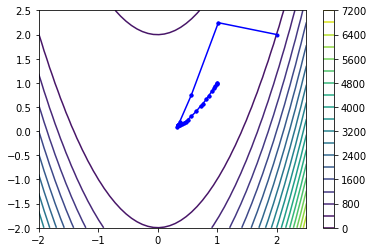

In [11]:
# Parameters
a = 1
b = 100

# Initial guess
x0 = np.array([2*a,2*a])

# Objective function and gradient
fun = lambda x: (a-x[0])**2 + b*(x[1]-x[0]**2)**2
jac = lambda x: np.array([-2*(a-x[0])-2*x[0]*2*b*(x[1]-x[0]**2),2*b*(x[1]-x[0]**2)])

# Plot function contours
plt.figure()
X = np.linspace(-2,2.5)
Y = np.linspace(-2,2.5)
Z = np.meshgrid(X,Y)
plt.contour(X,Y,fun(Z),20)
plt.colorbar()

# Call SciPy's BFGS
xprev = x0 # for plotting
res = opt.minimize(fun, x0, method='BFGS', jac=jac, tol=1e-1, callback=callback)

# Print results and show plot
print(res)
plt.show()

### 2.2.4 Limited-Memory Quasi-Newton
Recall that limited-memory Quasi-Newton is a variant of Quasi-Newton which stores only the last $m$ values of $s^k$ and $y^k$ for some small $m$. 

#### Coding Task: 
Now apply Scipy's L-BFGS-B starting from $x^0 = (2a,2a)$ to solve the above problem for $a=1$ and $b=100$. Then try again from $x^0 = (10a,10a)$.

      fun: 6.758747192886498e-10
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00059594,  0.00031851])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 28
      nit: 25
     njev: 28
   status: 0
  success: True
        x: array([1.00002055, 1.00004269])


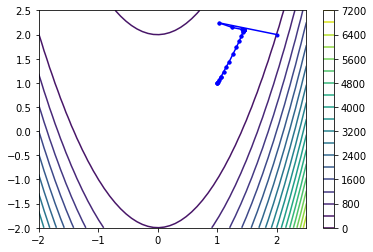

In [12]:
# Parameters
a = 1
b = 100
m = 10

# Initial guess
x0 = np.array([2*a,2*a])

# Objective function and gradient
fun = lambda x: (a-x[0])**2 + b*(x[1]-x[0]**2)**2
jac = lambda x: np.array([-2*(a-x[0])-2*x[0]*2*b*(x[1]-x[0]**2),2*b*(x[1]-x[0]**2)])

# Plot function contours
plt.figure()
X = np.linspace(-2,2.5)
Y = np.linspace(-2,2.5)
Z = np.meshgrid(X,Y)
plt.contour(X,Y,fun(Z),20)
plt.colorbar()

# Call SciPy's L-BFGS-B
xprev = x0 # for plotting
res = opt.minimize(fun, x0, method='L-BFGS-B', jac=jac, callback=callback, options=dict(ftol=1e-5,maxcor=m))

# Print results and show plot
print(res)
plt.show()

#### Exercises: 

1. Compare the number of objective function, gradient and Hessian evaluations across the different linesearch methods above (these are reported as nfev, njev and nhev in the outputs above). What do you observe?